In [27]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import contextily as ctx
from numpy import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

# XGBoost (oversampling)

## Load data

In [28]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

378

In [29]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [30]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [31]:
# df = df.drop(columns=['soil region', 'landuse code'])
df = df.drop(columns=['landuse code'])
df = df.dropna()
len(df)

239

## Add year and month as features

In [32]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [33]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [34]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
soil region                            category
population                              float64
groundwater depth                       float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
month                                     int32
year                                      int32
dtype: object

## Remove nitrate outliers

In [35]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 20


,bro-id,nitrate,geometry,date,soil region,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,month,year
13,GAR000000050444,14.00,POINT (4008056.9446916794 3219955.9360334864),2008-09-16 10:00:00+00:00,zand,15.0,5.036337,15.743617,5.439744,52.001456,2.25,173.216667,26.221104,Dikke eerdgronden,4.8,1.395,4.4,9,2008
22,GAR000000000295,14.00,POINT (3996036.45000483 3237918.6928582876),2008-09-16 10:00:00+00:00,zand,0.0,2.477353,12.854752,5.247944,52.155612,2.25,173.216667,29.106546,Podzolgronden,4.2,1.422,3.9,9,2008
66,GAR000000000296,13.85,POINT (3996036.45000483 3237918.6928582876),2010-03-16 10:00:00+00:00,zand,0.0,2.399292,12.854752,5.247944,52.155612,26.00,17.400000,24.246117,Podzolgronden,4.2,1.422,3.9,3,2010
78,GAR000000050426,15.37,POINT (4001172.2075030133 3222568.6973343277),2010-03-17 10:00:00+00:00,zand,45.0,2.605271,5.790982,5.337232,52.020971,25.75,18.633333,18.797394,Dikke eerdgronden,4.8,1.395,5.6,3,2010
87,GAR000000000645,12.35,POINT (4004844.615593101 3221714.3460609964),2010-03-19 10:00:00+00:00,zand,15.0,5.096111,20.816914,5.391427,52.015408,7.00,21.200000,25.394691,Kalkloze zandgronden,3.0,1.473,3.6,3,2010
91,GAR000000050428,14.15,POINT (4008056.9446916794 3219955.9360334864),2010-03-22 10:00:00+00:00,zand,15.0,5.164219,15.743617,5.439744,52.001456,58.50,24.633333,22.089039,Dikke eerdgronden,4.8,1.395,4.4,3,2010
92,GAR000000000825,19.47,POINT (4017541.5994892335 3216847.3002120424),2010-03-23 10:00:00+00:00,zand,10.0,6.743562,8.355708,5.580385,51.978827,52.00,25.900000,22.775382,Kalkloze zandgronden,5.5,1.368,5.3,3,2010
101,GAR000000000783,31.01,POINT (4018830.856405632 3214943.5346370544),2010-03-24 10:00:00+00:00,zand,40.0,6.743972,12.048532,5.600794,51.962454,0.75,27.750000,26.403195,Dikke eerdgronden,2.0,1.425,4.5,3,2010
123,GAR000000000784,29.37,POINT (4018830.856405632 3214943.5346370544),2012-02-23 10:00:00+00:00,zand,40.0,6.813979,12.048532,5.600794,51.962454,8.75,29.466667,27.383685,Dikke eerdgronden,2.0,1.425,4.5,2,2012
148,GAR000000050446,12.13,POINT (4008056.9446916794 3219955.9360334864),2012-03-20 10:00:00+00:00,zand,15.0,5.234420,15.743617,5.439744,52.001456,1.50,34.000000,23.741865,Dikke eerdgronden,4.8,1.395,4.4,3,2012


<Axes: >

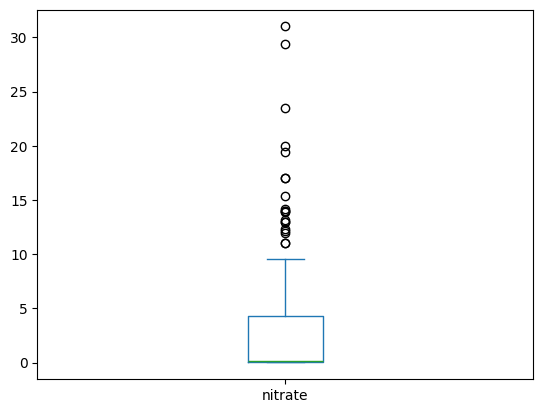

In [36]:
df[["nitrate"]].plot(kind = "box")

In [37]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-3:].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [38]:
n = len(df)
train_size = int(n * 0.8)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 191
Test: 48


In [39]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Define Box-Cox

In [40]:
offset = 1e-5
y_train_bc_input = y_train + offset

# Fit Box-Cox and get optimal lambda
y_train_boxcox, fitted_lambda = boxcox(y_train_bc_input)
print("Box-Cox λ:", fitted_lambda)

# transformation functions
def boxcox_transform(y):
    return boxcox(y + offset, lmbda=fitted_lambda)

def boxcox_inverse(y):
    return inv_boxcox(y, fitted_lambda) - offset

Box-Cox λ: -0.05194304436375203


## Add weights

In [41]:
sample_weights = np.maximum(y_train, 1)
sample_weights /= sample_weights.mean()

## Preprocess data

In [42]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [43]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soil region', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['soil region', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [44]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [45]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=4
)

In [46]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=boxcox_transform,
    inverse_func=boxcox_inverse
)

In [47]:
param_dist = {
    "regressor__xgb__n_estimators": [30, 50, 100],
    "regressor__xgb__max_depth": [5, 7, 8],
    "regressor__xgb__learning_rate": [0.05, 0.1, 0.15],
    "regressor__xgb__subsample": [0.6, 0.8, 1.0],
    "regressor__xgb__colsample_bytree": [0.3, 0.4, 0.6]
}

## Hyperparameter tuning

In [48]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train, xgb__sample_weight=sample_weights)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [49]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 1.640000475712457
Best params: {'regressor__xgb__subsample': 0.6, 'regressor__xgb__n_estimators': 50, 'regressor__xgb__max_depth': 7, 'regressor__xgb__learning_rate': 0.1, 'regressor__xgb__colsample_bytree': 0.6}


## Learning curve

In [50]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [51]:
n = len(X_train)

train_errors = []
val_errors = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))

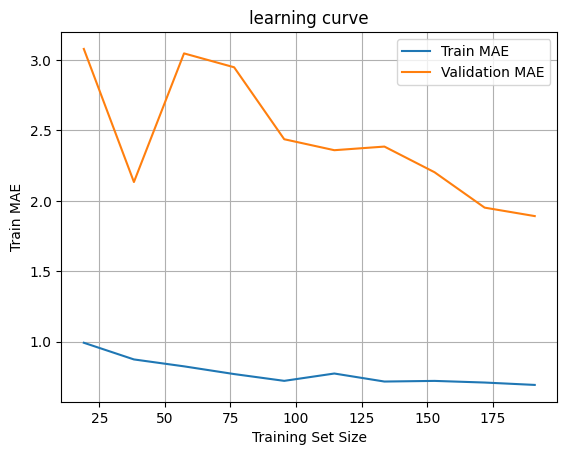

In [52]:
plt.plot(train_sizes * len(X_train), train_errors, label="Train MAE")
plt.plot(train_sizes * len(X_train), val_errors, label="Validation MAE")
plt.xlabel("Training Set Size")
plt.ylabel("Train MAE")
plt.title("learning curve")
plt.legend()
plt.grid(True)
plt.show()

## Train model

In [53]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function boxcox_transform at 0x107baa820>,
                           inverse_func=<function boxcox_inverse at 0x332f44160>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        '...
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=50,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   random_state=4, ...))]))

## Final Train score

In [54]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9251259011531421
Train MAE: 0.5559034205640798
Test RMSE: 1.4348778757875855


## Final Test score

In [55]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test, pred_nitrate))
print("Test MAE:",mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.696255517468104
Test MAE: 0.5559034205640798
Test RMSE: 2.0436732413432277


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

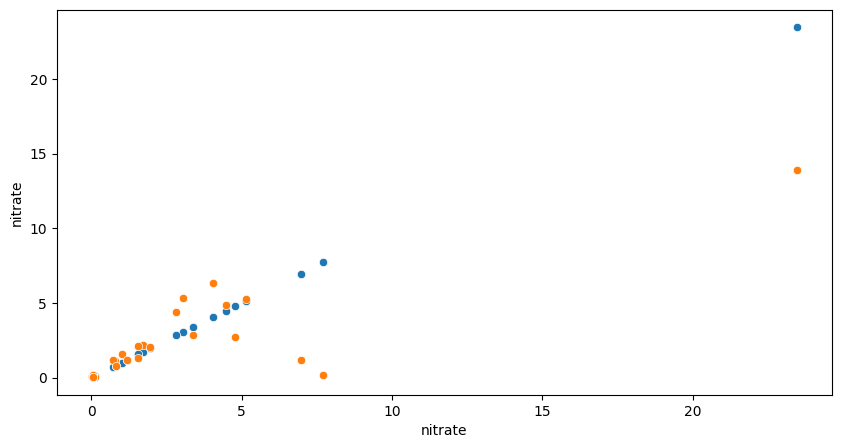

In [56]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

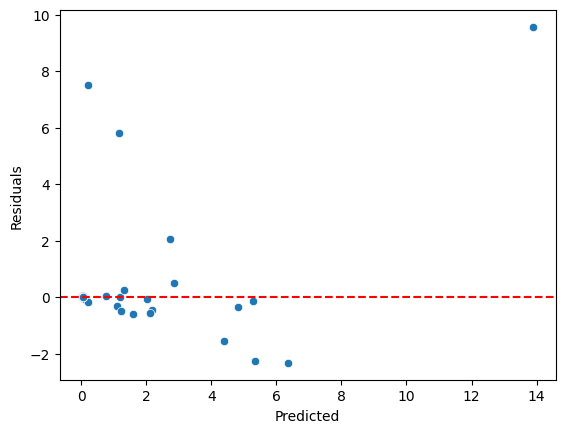

In [57]:
preds = best_model.predict(X_test)

residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [58]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

48
48
48
48


In [59]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

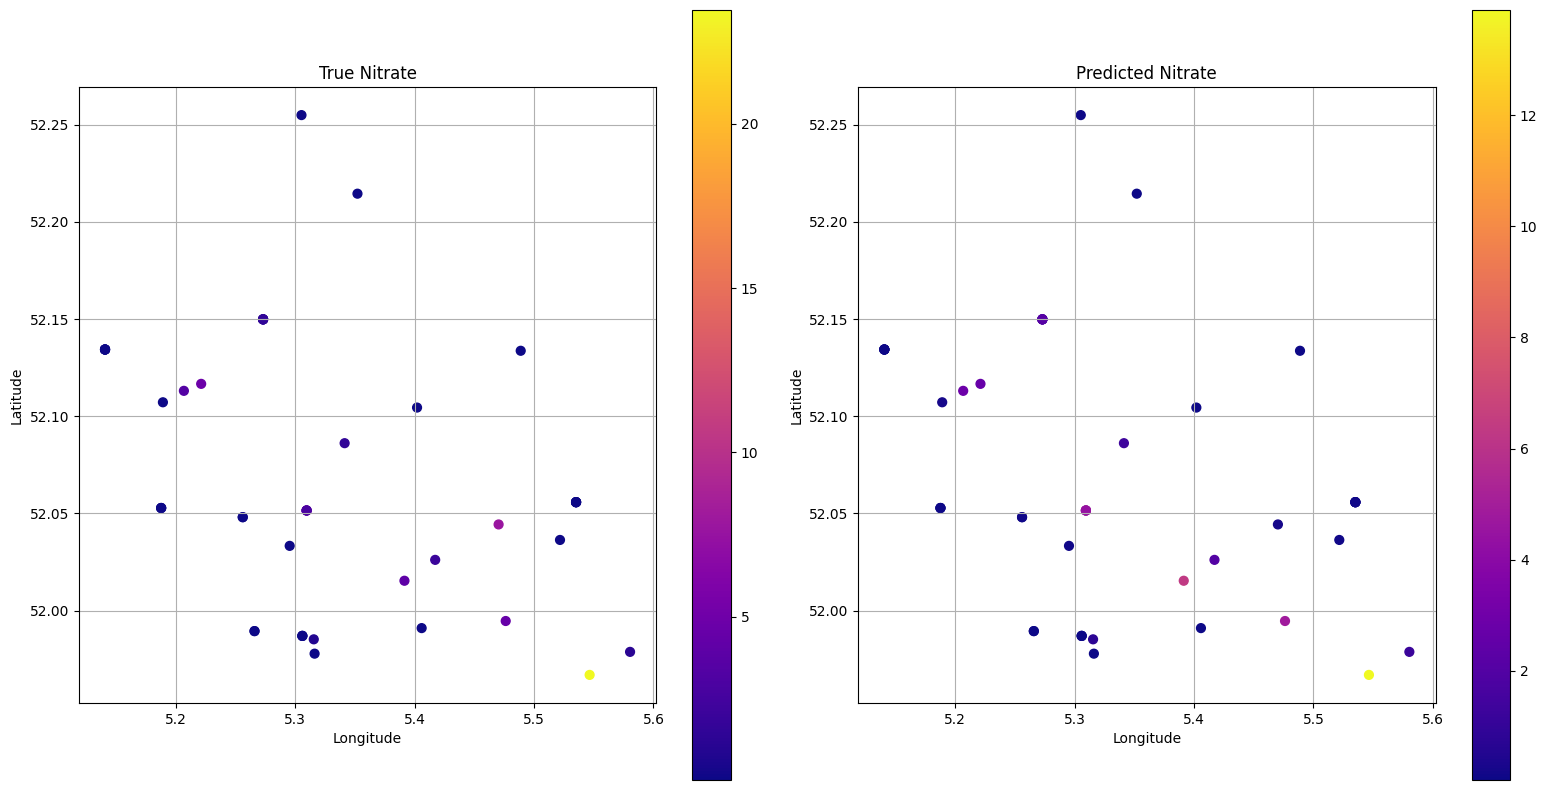

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

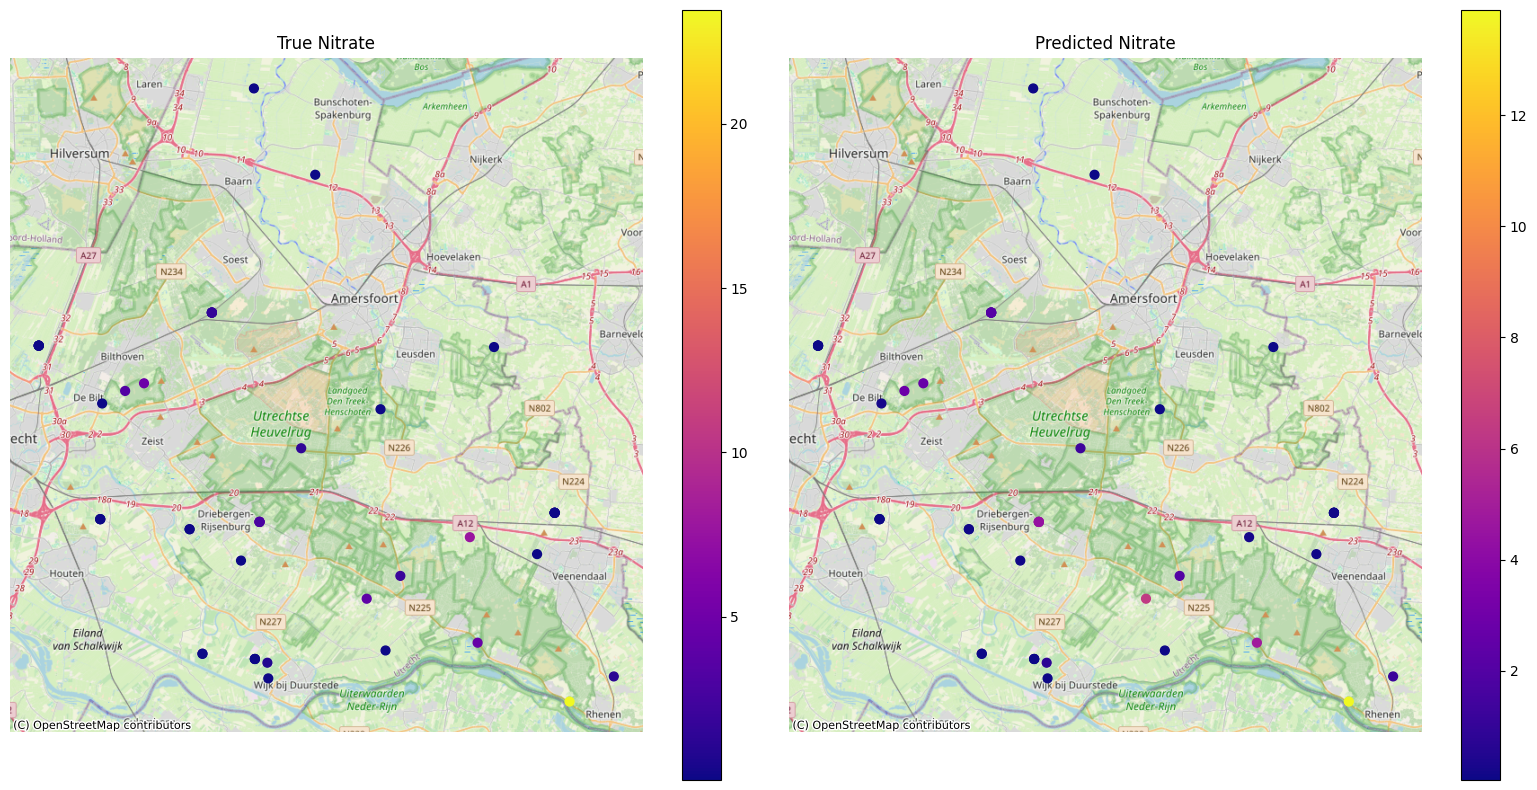

In [61]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Interpretability

In [62]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function boxcox_transform at 0x107baa820>,
                           inverse_func=<function boxcox_inverse at 0x332f44160>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        '...
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=50,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   random_state=4, ...))]))

In [63]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [64]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['xgb']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [65]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature  importance
18                              num_scaler__acidity_1    0.271240
16                 num_scaler__organicmattercontent_1    0.186381
7   cat_ohe__mainsoilclassification_1_Rivierkleigr...    0.103937
3   cat_ohe__mainsoilclassification_1_Dikke eerdgr...    0.101393
12                              num_scaler__elevation    0.093511
17                              num_scaler__density_1    0.087369
6     cat_ohe__mainsoilclassification_1_Podzolgronden    0.045006
10                             num_scaler__population    0.019537
4   cat_ohe__mainsoilclassification_1_Kalkloze zan...    0.016734
14                            num_scaler__temperature    0.013150
11                      num_scaler__groundwater depth    0.012290
13                          num_scaler__precipitation    0.011103
15                           num_scaler__n deposition    0.010860
0                           cat_ohe__soil region_klei    0.009374
5   cat_oh

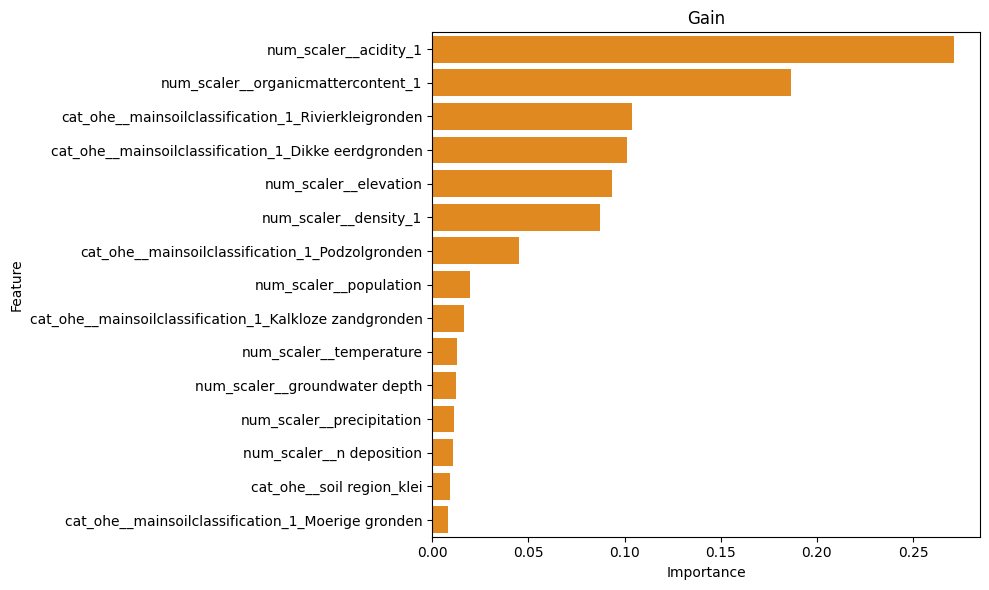

In [66]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [67]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [68]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

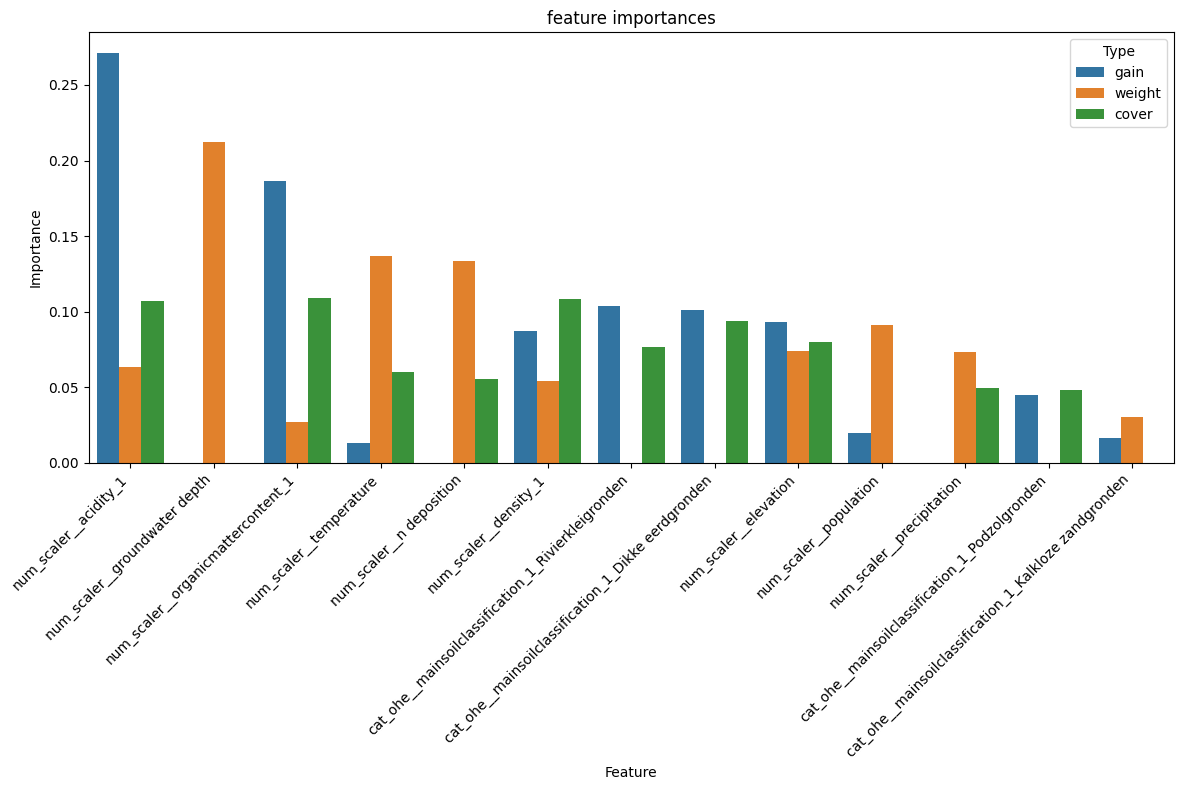

In [69]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [70]:
assert fitted_model.n_features_in_ == len(feature_names)

In [71]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

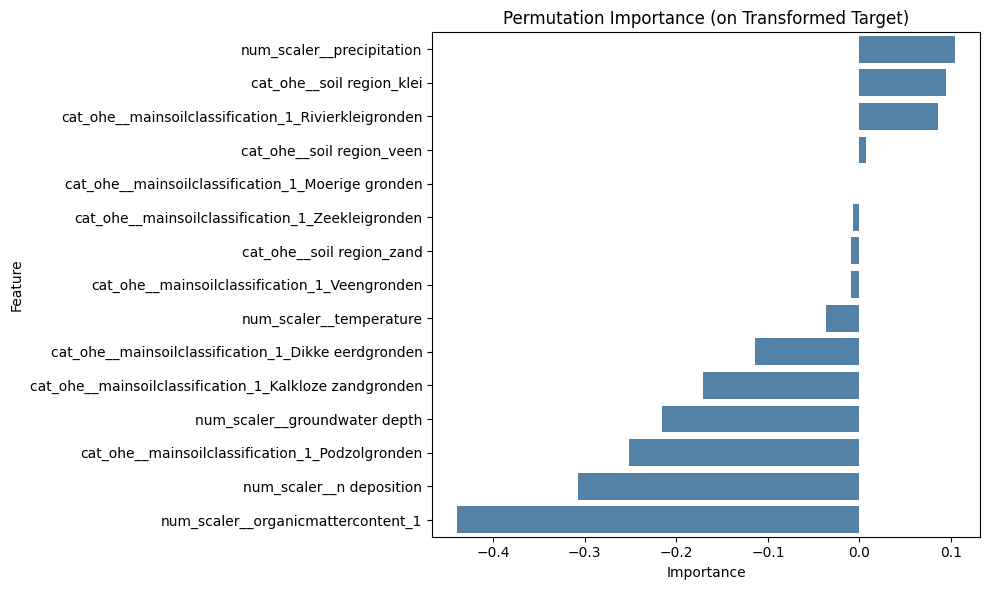

In [72]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [73]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [74]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__soil region_klei,0.009374,gain,NaN
1,cat_ohe__soil region_veen,0.000800,gain,NaN
2,cat_ohe__soil region_zand,0.005172,gain,NaN
3,cat_ohe__mainsoilclassification_1_Dikke eerdgr...,0.101393,gain,NaN
4,cat_ohe__mainsoilclassification_1_Kalkloze zan...,0.016734,gain,NaN
...,...,...,...,...
16,num_scaler__organicmattercontent_1,0.101845,permutation,0.161836
12,num_scaler__elevation,0.112171,permutation,0.425661
10,num_scaler__population,0.113332,permutation,0.178434
18,num_scaler__acidity_1,0.169411,permutation,0.356327


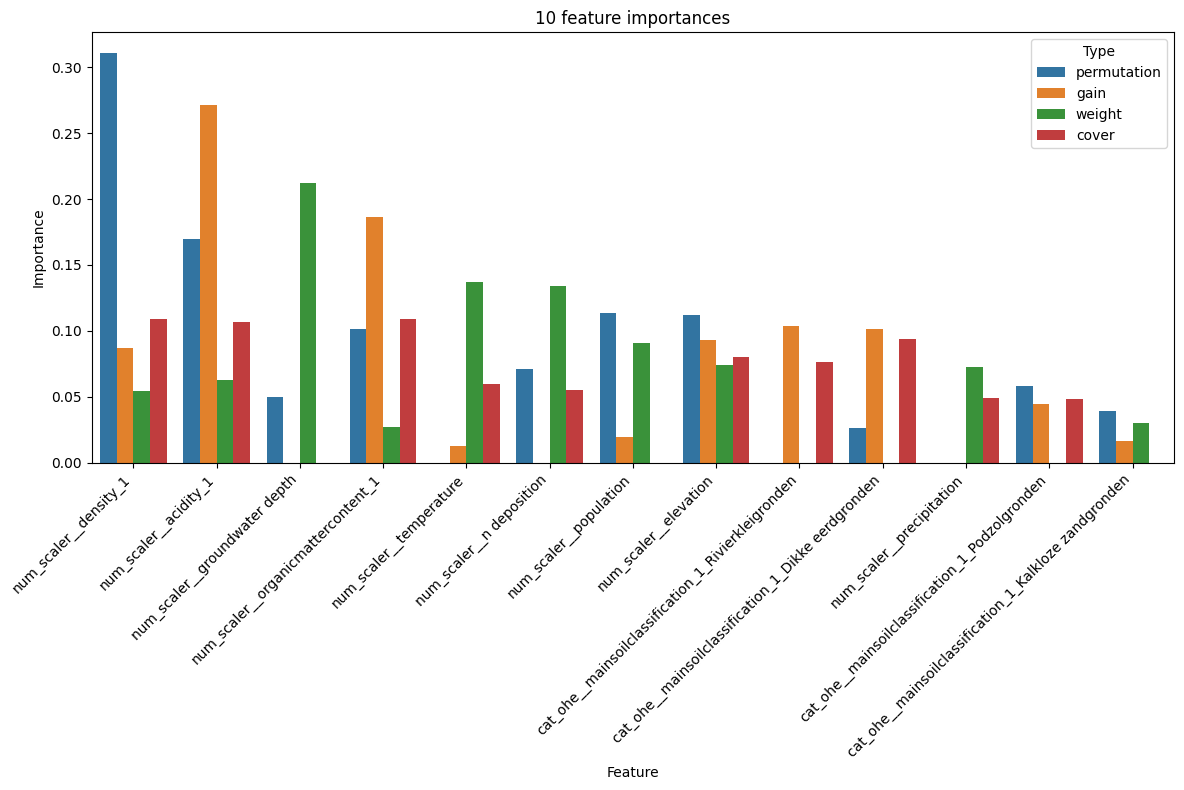

In [75]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

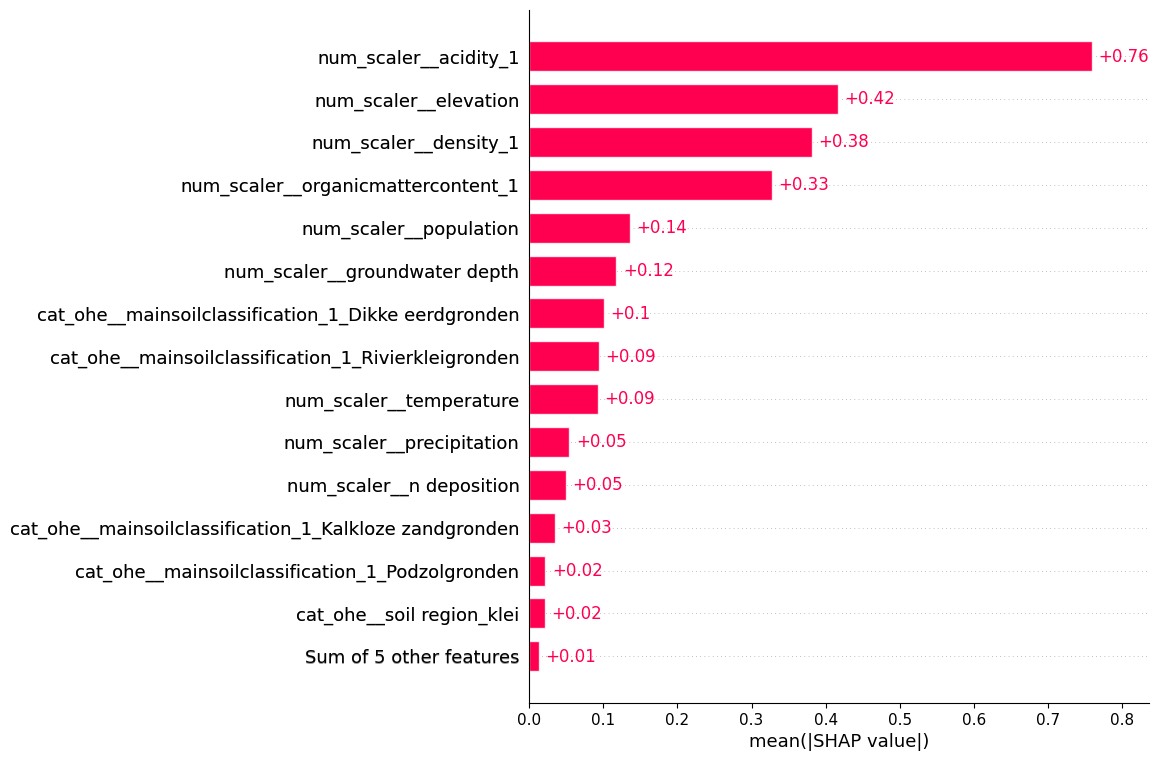

In [76]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


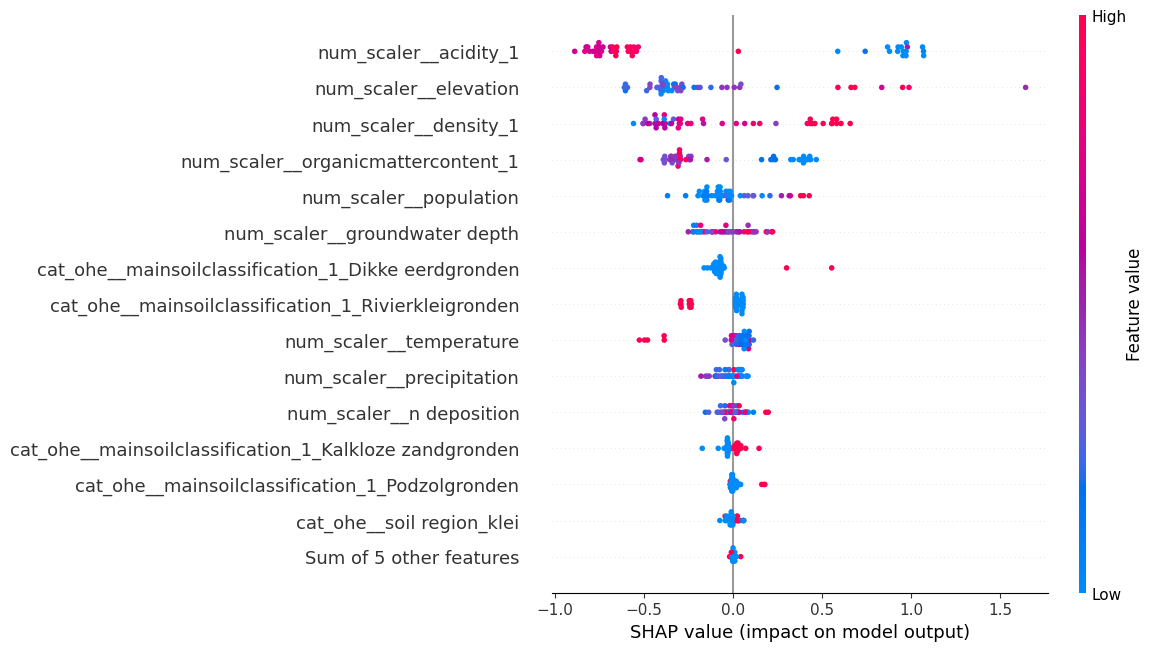

In [77]:
shap.plots.beeswarm(shap_explanation, max_display=15)